In [ ]:
#Binary Classification of fetal ultrasound images using a ResNet50 Architecture and Segmented datase

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
#define path to dataset
import pathlib

train_dir = 'C:\\Users\\saniy\\Documents\\Rishi work\\ResNet\\Seg\\Segmented-Dataset\\Training'

val_dir = 'C:\\Users\\saniy\\Documents\\Rishi work\\ResNet\\Seg\\Segmented-Dataset\\Testing'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 720 files belonging to 2 classes.


In [3]:
validation_dataset = image_dataset_from_directory(val_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 180 files belonging to 2 classes.


In [4]:
class_names = train_dataset.class_names
print(class_names)

['Bad', 'Good']


In [ ]:
#autotune to increase data performance

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)


In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
#visualise dataset after data augmentation

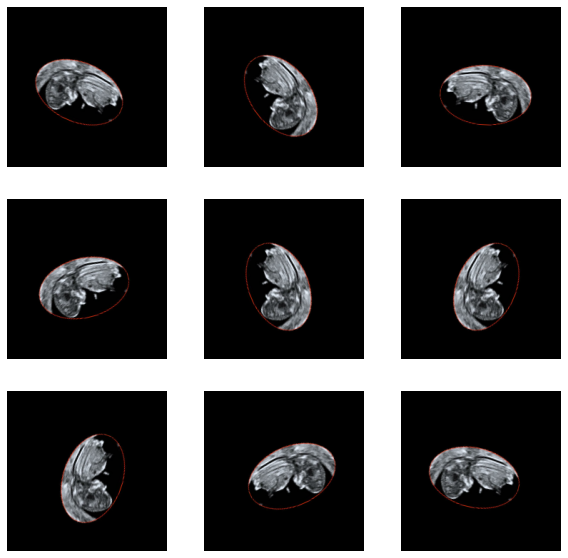

In [7]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
#image preprocessing using vgg16

In [8]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [9]:
# Create the base model from the pre-trained model VGG16 model
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [10]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


In [ ]:
#set trainable to false

In [11]:
base_model.trainable = False

In [12]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [14]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
#compile layers of model

In [15]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
base_learning_rate = 0.0002
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

In [18]:
len(model.trainable_variables)

2

In [ ]:
#initial evaluation of the model

In [19]:
initial_epochs = 50

loss0, accuracy0 = model.evaluate(validation_dataset)

6/6 [==============================] - 33s 5s/step - loss: 1.5860 - accuracy: 0.5007


In [20]:
#fit the model and record time taken
import time
start = time.time()
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/50
23/23 [==============================] - 173s 8s/step - loss: 1.7085 - accuracy: 0.4958 - val_loss: 1.0228 - val_accuracy: 0.5167
Epoch 2/50
23/23 [==============================] - 169s 7s/step - loss: 1.4539 - accuracy: 0.5222 - val_loss: 0.9534 - val_accuracy: 0.5389
Epoch 3/50
23/23 [==============================] - 170s 7s/step - loss: 1.4935 - accuracy: 0.5181 - val_loss: 0.9059 - val_accuracy: 0.5556
Epoch 4/50
23/23 [==============================] - 169s 7s/step - loss: 1.4244 - accuracy: 0.5125 - val_loss: 0.8732 - val_accuracy: 0.5667
Epoch 5/50
23/23 [==============================] - 169s 7s/step - loss: 1.2883 - accuracy: 0.5514 - val_loss: 0.8318 - val_accuracy: 0.5889
Epoch 6/50
23/23 [==============================] - 170s 7s/step - loss: 1.2712 - accuracy: 0.5194 - val_loss: 0.8012 - val_accuracy: 0.6167
Epoch 7/50
23/23 [==============================] - 170s 7s/step - loss: 1.1608 - accuracy: 0.5556 - val_loss: 0.7887 - val_accuracy: 0.6333
Epoch 8/50
23

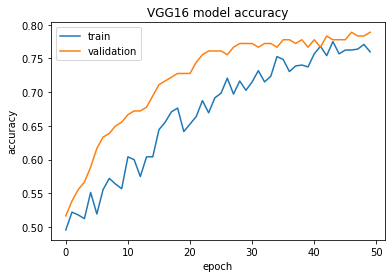

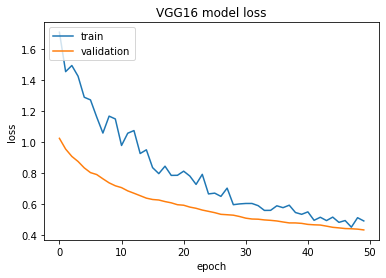

In [21]:
stop = time.time()
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG16 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Model-accuracy-VGG16-6Seg.svg')
plt.show()
    
    # "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])    
plt.title('VGG16 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Model-loss-VGG16-6Seg.svg')
plt.show()



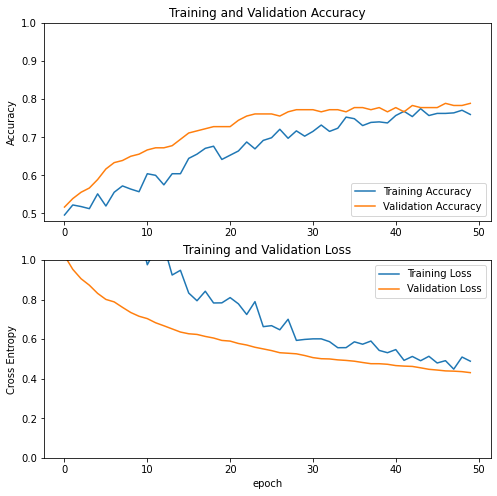

In [22]:
#produce bigger learning curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
#Save model
model.save("vgg16seg.h5")

['Bad', 'Good']
bad
[[5.0228868]]


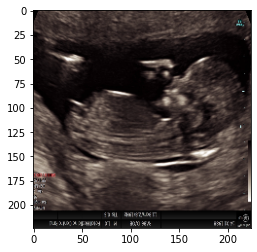

In [35]:
#test individual images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from keras.preprocessing import image
from cv2 import *
import numpy as np
import matplotlib.image as mpimg
from keras.preprocessing import image
img = cv2.imread('/Users/RishiSingh/crl-images/dataset/single_prediction/CRL (180).jpg')
img = cv2.resize(img, (224,224))
plt.imshow(img)
test_image = image.load_img('/Users/RishiSingh/crl-images/dataset/single_prediction/CRL (180).jpg', target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(class_names)
if result[0][0] <0.5:
    prediction = 'good'
else:
    prediction = 'bad'
print(prediction)
print(result)




In [24]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)

In [25]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 7s 7s/step - loss: 0.3337 - accuracy: 0.8438
Test accuracy : 0.84375


In [26]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

In [27]:
# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

Predictions:
 [1 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1]
Labels:
 [1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 1]


In [28]:
#produce Confusion matrix
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report,accuracy_score,precision_score,recall_score,f1_score,roc_curve
import pandas as pd
import seaborn as sns
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')
    plt.savefig('ResNet50CM1.svg')

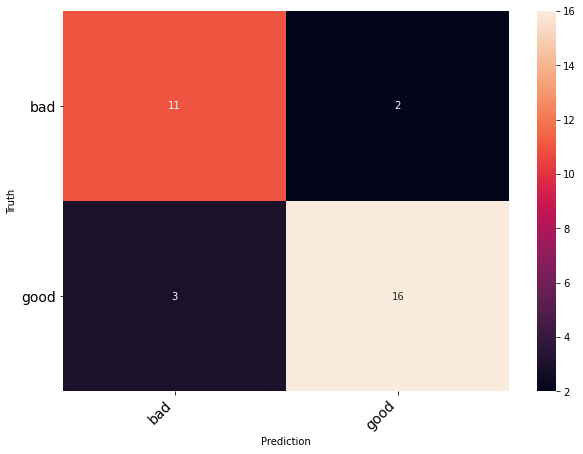

In [29]:
cm = confusion_matrix(label_batch,predictions.numpy())
print_confusion_matrix(cm,["bad","good"])

In [30]:
print(classification_report(label_batch,predictions.numpy()))

              precision    recall  f1-score   support

           0       0.79      0.85      0.81        13
           1       0.89      0.84      0.86        19

    accuracy                           0.84        32
   macro avg       0.84      0.84      0.84        32
weighted avg       0.85      0.84      0.84        32

